<h1>
<center>CFRM 421/521, Spring 2022</center>
</h1>

<h1>
<center>Rohan Tiwari</center>
</h1>

<h1>
<center>Homework 4</center>
</h1>

* **Due: Tuesday, May 31, 2022, 11:59 PM**


* Total marks: 47


* Late submissions are allowed, but a 20% penalty per day applies. Your last submission is considered for calculating the penalty.


*  Use this Jupyter notebook as a template for your solutions. **Your solution must be submitted as one Jupyter notebook on Canvas and one PDF file on Gradescope.** The notebook must be already run, that is, make sure that you have run all your code, save the notebook, and then when you reopen the notebook, checked that all output appears as expected. You are allowed to use code from the textbook, textbook website, or lecture notes.

# 1. A regression MLP [10 marks]

Consider the California housing data from Homework 1 using the same training and test set there. Here, we split off 20% of the training set as a validation set, and keep the remaining 80% as the actual training set.  The following code replicates the preprocessing of the dataset from Homework 1, creating the training set `X_train`, `y_train`, the validation set `X_valid`, `y_valid` and the test set `X_test`, `y_test`. The target variable has been divided by 100,000.

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit

import os
import tarfile
from six.moves import urllib

HOUSING_PATH = os.path.join("datasets", "housing")

def fetch_housing_data(housing_url, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

HOUSING_URL = ("https://raw.githubusercontent.com/ageron/"+
               "handson-ml2/master/datasets/housing/housing.tgz")
fetch_housing_data(HOUSING_URL)
data = load_housing_data()

data["income_cat"] = np.ceil(data["median_income"] / 1.5)
data["income_cat"].where(data["income_cat"] < 5, 5.0, inplace=True)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
    
# Split the traning set into training and validation    
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index2, valid_index in split2.split(strat_train_set, strat_train_set["income_cat"]):
    strat_train2_set = strat_train_set.iloc[train_index2]
    strat_valid_set = strat_train_set.iloc[valid_index]
    
strat_train_set = strat_train2_set.copy().drop("income_cat", axis=1)
strat_valid_set = strat_valid_set.copy().drop("income_cat", axis=1)
strat_test_set = strat_test_set.copy().drop("income_cat", axis=1)

X_raw = strat_train_set.drop("median_house_value", axis=1)
y_train = strat_train_set["median_house_value"].copy()/100000

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
num_features = X_raw.drop("ocean_proximity", axis=1)
num_attribs = list(num_features)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

# Apply the pipeline to the training set
X_train = full_pipeline.fit_transform(X_raw)

# Apply the pipeline to the validation set
X_valid_raw = strat_valid_set.drop("median_house_value", axis=1)
y_valid = strat_valid_set["median_house_value"].copy()/100000
X_valid = full_pipeline.transform(X_valid_raw)

# Apply the pipeline to the validation set
X_test_raw = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()/100000
X_test = full_pipeline.transform(X_test_raw)

## (a) [4 marks]

Use `tensorflow.keras` to train a regression MLP with one hidden layer of 50 ReLU neurons. For the output layer, try both a ReLU activation function and no activation function (which is equivalent to the identity function). Explain which choice is better. Use the appropriate weight initialization. Use the Ndamn optimizer. Train for 30 epochs, and report the mean squared error on the validation set.

Hint: In the `.compile()` method, use `loss="mse"`.

**[Add your solution here]**

In [8]:
import random as python_random
import numpy as np
def reset_session(seed=42):
    tf.random.set_seed(seed)
    python_random.seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

In [33]:
import tensorflow as tf
from tensorflow import keras
reset_session()
model = keras.models.Sequential()
model.add(keras.layers.Dense(50, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(1, activation="relu", kernel_initializer="he_normal"))
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss="mean_squared_error",optimizer=optimizer)
model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid), verbose=0)
print("Mse on validation set is: ", model.evaluate(X_valid, y_valid))


104/104 [==============================] - 0s 1ms/step - loss: 0.3387
Mse on validation set is:  0.33870571851730347


In [35]:
reset_session()

model = keras.models.Sequential()
model.add(keras.layers.Dense(50, activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(1))
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss="mean_squared_error",optimizer=optimizer)
model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid), verbose=0)
print("Mse on validation set is: ", model.evaluate(X_valid, y_valid))

104/104 [==============================] - 0s 1ms/step - loss: 0.3393
Mse on validation set is:  0.339341938495636


We see that with relu activation the mse is lower and the loss drops faster so it is better

## (b) [5 marks]

Read the section "Fine-Tuning Neural Network Hyperparameters" in the textbook and the corresponding section in the [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb) on the textbook website. Then use a randomized search to search for the best number of hidden layers, neurons per hidden layer, and learning rate. For the randomized search use 3-fold CV, with 10 iterations, with the number of hidden layers uniformly sampled from $\{0,1,2,3\}$, the number of neurons per layer uniformly from $\{1,2,\dots,100\}$, and the learning rate from the distribution `reciprocal(3e-4, 3e-2)`. Use early stopping with `patience=10`.

In [24]:
import tensorflow as tf

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=X_train.shape[1:]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, kernel_initializer="he_normal", activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    model.compile(loss="mse", optimizer=optimizer)
    return model
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  if sys.path[0] == '':


In [25]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
reset_session()
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100)               .tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2)      .rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=0)
rnd_search_cv.fit(X_train, y_train, epochs=30,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)], verbose=0)

138/138 [==============================] - 0s 1ms/step - loss: 0.2915


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f90746fd390>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.004779156784872302,
                                                          0.007821074275112298,...
                                                          0.00114704256

**[Add your solution here]**

In [26]:
rnd_search_cv.best_params_


{'learning_rate': 0.005803602934201024, 'n_hidden': 3, 'n_neurons': 74}

In [27]:
rnd_search_cv.best_score_


-0.299530287583669

In [28]:
rnd_search_cv.best_estimator_


In [29]:
model = rnd_search_cv.best_estimator_.model


## (c) [1 mark]

Plot the learning curves for the best model in (c). Does it look like the model is overfitting?

**[Add your solution here]**

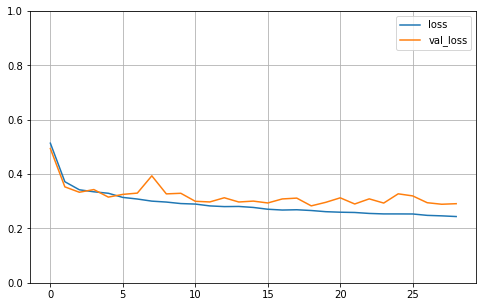

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(model.history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

There is some difference between training and validation set which does not seem to reduce but the gap is small. So there is some overfitting.

# 2. Binary classification DNN [23 marks]

Consider the [Caravan insurance data](https://liacs.leidenuniv.nl/~puttenpwhvander/library/cc2000/). The data gives sociodemographic and product ownership data from customers of an insurance company, some of which purchased caravan insurance. You can read ther data description from that website. Download the data as a csv file from [Canvas](https://canvas.uw.edu/files/92281351/download?download_frd=1).

The target variable is `Purchase`, which is binary and you should convert it to 1 for `Yes` and 0 for `No`.

## (a) [3 marks]

Load, split and preprocess the data. In particular, for the splitting, you will need to create a test set (20% of the full data), a validation set (20% of the remaining data after creating the test set), and a training set, and stratify using the target variable because this is an imbalanced dataset. For both splits, use `random_state=42`. The features `MOSTYPE` and `MOSHOOFD` are categorical so one hot encoding needs to be applied to them. All other features are numerical so a standard scaler needs to be applied to them. Print the training set `X_train`, `y_train` using `print()`.

**[Add your solution here]**

In [36]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import copy

data = pd.read_csv('caravan.csv')
data["Purchase"] = (data["Purchase"] == "Yes").astype(int)

s1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index_orig, test_index = next(s1.split(data, data["Purchase"]))
strat_train_set_orig = data.loc[train_index_orig]
strat_test_set = data.loc[test_index]

s2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, val_index=next(s2.split(strat_train_set_orig, strat_train_set_orig["Purchase"]))
strat_train_set = copy.deepcopy(strat_train_set_orig.iloc[train_index])
strat_valid_set = copy.deepcopy(strat_train_set_orig.iloc[val_index])

#X_raw = strat_train_set.drop("Purchase", axis=1)
#y_train = strat_train_set["Purchase"]

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

X_train_raw = strat_train_set.drop("Purchase", axis=1)

num_attribs = list(X_train_raw.drop(["MOSTYPE","MOSHOOFD"], axis=1))
cat_hot_attribs = ["MOSTYPE",'MOSHOOFD']

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat_hot", OneHotEncoder(), cat_hot_attribs)
    ])

y_train = strat_train_set["Purchase"].copy()
X_train = full_pipeline.fit_transform(X_train_raw)

X_valid_raw = strat_valid_set.drop("Purchase", axis=1)
y_valid = strat_valid_set["Purchase"].copy()
X_valid = full_pipeline.fit_transform(X_valid_raw)

X_test_raw = strat_test_set.drop("Purchase", axis=1)
y_test = strat_test_set["Purchase"].copy()
X_test = full_pipeline.fit_transform(X_test_raw)

In [37]:
print(X_train)

[[-0.26920841  0.40025864  0.00630108 ...  0.          0.
   0.        ]
 [-0.26920841 -0.87080994  1.24164497 ...  0.          0.
   0.        ]
 [-0.26920841 -0.87080994  0.00630108 ...  1.          0.
   0.        ]
 ...
 [-0.26920841  1.67132722  0.00630108 ...  0.          0.
   0.        ]
 [-0.26920841  0.40025864 -1.2290428  ...  0.          0.
   0.        ]
 [-0.26920841  0.40025864  0.00630108 ...  1.          0.
   0.        ]]


In [38]:
print(y_train)

5356    0
2968    0
1180    0
5182    0
2623    0
       ..
219     0
1701    0
5360    0
978     0
4062    0
Name: Purchase, Length: 3725, dtype: int64


## (b) [3 marks]

In the next part (c), you will build and fit a DNN with 5 hidden layers of 200, 200, 100, 100, 50 neurons, respectively. Use the following specifications:

(i) He initialization and the ELU activation function.

(ii) The output layer has 1 neuron with sigmoid activation.

(iii) Compile with `loss="binary_crossentropy"` and  `metrics=["AUC"]` (which is ROC AUC).

In this question, explain why the choices (i), (ii), and (iii) are justified.

**[Add your solution here]**

In [39]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

model = keras.models.Sequential([
    keras.layers.Dense(200, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(200, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(1, activation="sigmoid")
])
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["AUC"])

Because we are doing a binary classification task, we should use sigmoid activation in the output layer and also use "binary_crossentropy" in the loss function. 
To avoid vanishing and exploding gradient problems, it is a good to use he_normal in kernel initialization when ELU function is used. 

## (c) [3 marks]

Train the model in (b) for 30 epochs and use exponential scheduling and the NAG optimizer with `momentum=0.9`. Use a learning curve to comment on whether it is overfitting.

At the start of fitting your model, run `reset_session()` given by the following code.

In [40]:
import random as python_random

def reset_session(seed=42):
    tf.random.set_seed(seed)
    python_random.seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()
reset_session()

def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history_sigmoid = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid), callbacks=[lr_scheduler], verbose=0)

model.evaluate(X_valid, y_valid)

30/30 [==============================] - 0s 2ms/step - loss: 0.3881 - auc: 0.6500


[0.38805896043777466, 0.6500427722930908]

(0.0, 1.0)

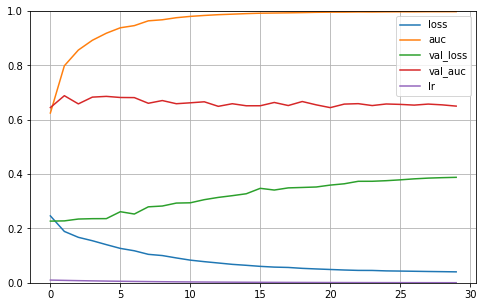

In [41]:
import matplotlib.pyplot as plt
pd.DataFrame(history_sigmoid.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)

The model clearly is overfitting because there is a large gap between training and validation curves.

**[Add your solution here]**

## (d) [12 marks]

Fit separate models using the same specification as in (c) but with the following regularization techniques:

(i) batch normalization,

(ii) early stopping based on validation AUC with `patience=10` (look at the documentation and note the `mode` argument).

(iii) $\ell_2$ regularization with `l2=0.001`,

(iv) dropout with probability 0.2,

(v) $\ell_2$ regularization and early stopping both as above,

(vi) batch normalization and dropout both as above.

At the start of each one of the above models, run `reset_session()`.

The performance measure is validation AUC. State this for the model in (c), and for each of the models here comment on whether it is better than the model in (c).

**[Add your solution here]**

Batch Normalization

In [42]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

model_a = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(200, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(200, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation="sigmoid")
])
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model_a.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["AUC"])

reset_session()

def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history_sigmoid = model_a.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid), callbacks=[lr_scheduler], verbose=0)

model_a.evaluate(X_valid, y_valid)

30/30 [==============================] - 0s 4ms/step - loss: 0.3195 - auc: 0.6304


[0.3194657266139984, 0.6304121613502502]

This is not better than model in (c)

early stopping based on validation AUC with `patience=10` (look at the documentation and note the `mode` argument).

In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

model_b = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(200, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(200, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(1, activation="sigmoid")
])
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model_b.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["AUC"])

reset_session()

def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_auc",
                                                  patience=10,
                                                  mode="max")
history_sigmoid = model_b.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid), callbacks=[lr_scheduler, early_stopping_cb], verbose=0)

model_b.evaluate(X_valid, y_valid)

30/30 [==============================] - 0s 3ms/step - loss: 0.3058 - auc: 0.6659


[0.3058452904224396, 0.6659430265426636]

This is better than model in (c)

ℓ2  regularization with l2=0.001

In [44]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

model_c = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(200, activation="elu", kernel_initializer="he_normal", 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(200, activation="elu", kernel_initializer="he_normal", 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(1, activation="sigmoid",
                       kernel_regularizer=keras.regularizers.l2(0.001))
])
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model_c.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["AUC"])

reset_session()

def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

history_sigmoid = model_c.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid), callbacks=[lr_scheduler], verbose=0)

model_c.evaluate(X_valid, y_valid)

30/30 [==============================] - 0s 2ms/step - loss: 1.1899 - auc: 0.6657


[1.1898795366287231, 0.6656780242919922]

This is better than model in (c)

dropout with probability 0.2

In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

model_d = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(200, activation="elu", kernel_initializer="he_normal", 
                       ),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(200, activation="elu", kernel_initializer="he_normal", 
                       ),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
                       ),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
                       ),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal",
                       ),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(1, activation="sigmoid",
                       )
])
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model_d.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["AUC"])

reset_session()

def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

history_sigmoid = model_d.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid), callbacks=[lr_scheduler], verbose=0)

model_d.evaluate(X_valid, y_valid)

30/30 [==============================] - 0s 2ms/step - loss: 0.2202 - auc: 0.6917


[0.22016139328479767, 0.6917094588279724]

This is better than model in (c)

ℓ2  regularization and early stopping both as above,

In [46]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

model_e = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(200, activation="elu", kernel_initializer="he_normal", 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(200, activation="elu", kernel_initializer="he_normal", 
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(1, activation="sigmoid",
                       kernel_regularizer=keras.regularizers.l2(0.001))
])
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model_e.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["AUC"])

reset_session()

def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_auc",
                                                  patience=10,
                                                  mode="max")

history_sigmoid = model_e.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid), callbacks=[lr_scheduler, early_stopping_cb], verbose=0)

model_e.evaluate(X_valid, y_valid)

30/30 [==============================] - 0s 6ms/step - loss: 1.1921 - auc: 0.6760


[1.192089319229126, 0.6760131120681763]

This is  better than model in (c)

batch normalization and dropout both as above.

In [47]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

model_f = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(200, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(200, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(1, activation="sigmoid")
])
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model_f.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["AUC"])

reset_session()

def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history_sigmoid = model_f.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid), callbacks=[lr_scheduler], verbose=0)

model_f.evaluate(X_valid, y_valid)

30/30 [==============================] - 0s 3ms/step - loss: 0.2191 - auc: 0.6896


[0.21914401650428772, 0.6895691156387329]

This is better than model in (c)

## (e) [1 mark]

For the dropout model in (d)(iv) determine whether or not it is overfitting less than the model in (c).

**[Add your solution here]**

(0.0, 1.0)

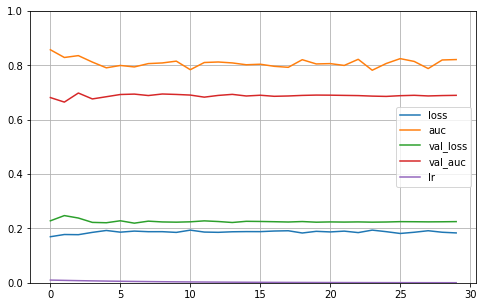

In [48]:
reset_session()
history = model_d.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid), callbacks=[lr_scheduler], verbose=0)

import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)

This is less overfitting than the model in c because the training and validation curves are closer.

## (f) [1 mark]

Of the models in (c) and (d), one would now choose the best model according to the performance metric (validation AUC) to evaluate on the test set. But instead, evaluate the model in (d)(v) on the test set in terms of the AUC and confusion matrix (regardless of whether it is the best model given your results).

**[Add your solution here]**

In [49]:
reset_session()
model_e.evaluate(X_test, y_test)

37/37 [==============================] - 0s 2ms/step - loss: 1.2107 - auc: 0.6125


[1.210672378540039, 0.612544059753418]

In [50]:
tf.math.confusion_matrix(y_test, model_e.predict(X_test))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1095,    0],
       [  70,    0]], dtype=int32)>

# 4. Time series using machine learning [14 marks]

Obtain daily values of the [Japan/U.S. Foreign Exchange Rate (DEXJPUS)](https://fred.stlouisfed.org/series/DEXJPUS) starting from Jan 1, 1990, to Jan 1, 2022, from FRED. This can be obtained using the code below or you can download the data as a csv file from [Canvas](https://canvas.uw.edu/files/92281350/download?download_frd=1).

In [51]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
data = pdr.get_data_fred('DEXJPUS', datetime(1990,1,1),datetime(2022,1,1))
data.head()

,DEXJPUS
DATE,
1990-01-01,NaN
1990-01-02,146.25
1990-01-03,145.70
1990-01-04,143.37
1990-01-05,143.82


## (a) [2 marks]

Create a training set (before 2010), a validation set (Jan 2010 to Dec 2015), and a test set (the rest of the data). Turn the time series data into a supervised learning dataset where the features are the value of the exchange rate in the last 10 days inclusive of the current day, and the target is the value of the exchange rate in the next day.

**[Add your solution here]**

In [52]:
def ts_split(ts, feature_steps=10, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                  for idx in range(n_obs)])
    return X, y

In [53]:
import pandas as pd
import numpy as np
import copy
d_train = data[:'2009-12-31'].dropna()
d_valid = data['2010-01-01':'2015-12-31'].dropna()
d_test = data['2016-01-01':].dropna()

In [54]:
X_train, y_train = ts_split(d_train.values.flatten())
X_valid, y_valid = ts_split(d_valid.values.flatten())
X_test, y_test = ts_split(d_test.values.flatten())

## (b) [3 marks]

Fit a random forest regressor to predict the value of the exchange rate in the next day. Using the test set, report the mean squared error and the accuracy for the movement direction.

Hint: You can calculate the accuracy of the movement direction by determining what the actual movement direction is and comparing it to the movement direction corresponding to the predicted value of the exchange rate. For instance, the movement direction of the test set `X_test` and `y_test` where a strictly up movement is `True` can be computed as follows.

In [ ]:
movement_test = X_test[:,-1] < y_test.ravel()

**[Add your solution here]**

In [55]:
from sklearn.ensemble import RandomForestRegressor
rnd_reg = RandomForestRegressor(random_state=42,n_jobs=-1)
rnd_reg.fit(X_train, np.ravel(y_train))

RandomForestRegressor(n_jobs=-1, random_state=42)

In [56]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

ypred = rnd_reg.predict(X_test)
print("Mean squared error is: ", mean_squared_error(y_test, np.ravel(ypred)))
movement_test = X_test[:,-1] < y_test.ravel()
movement_test_pred = X_test[:,-1] < ypred.ravel()

#print("accuracy is: " , accuracy_score(np.diff(np.ravel(y_test))>=0,np.diff(np.ravel(ypred))>=0))

print("accuracy is: " , accuracy_score(movement_test, movement_test_pred))


Mean squared error is:  0.37380881968392765
accuracy is:  0.5137861466039004


## (c) [4 marks]

Repeat (b), but now fit a deep RNN with 2 recurrent layers of 20 and 20 neurons, and an output layer which is 1 dense neuron. Use 100 epochs and the Nadam optimizer. Comment on the result and the learning curve (the validation set is used for the learning curve).

**[Add your solution here]**

In [57]:
def reset_session(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

In [58]:
import tensorflow as tf
from tensorflow import keras

reset_session()

keras_model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

keras_model.compile(loss="mse", optimizer="nadam")
history = keras_model.fit(X_train[..., np.newaxis], y_train, epochs=100,
                    validation_data=(X_valid[..., np.newaxis], y_valid), verbose=0)

In [59]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

ypred = keras_model.predict(X_test[..., np.newaxis])
print("Mean squared error is: ", mean_squared_error(y_test, ypred))
movement_test = X_test[:,-1] < y_test.ravel()
movement_test_pred = X_test[:,-1] < ypred.ravel()

#print("accuracy is: " , accuracy_score(np.diff(np.ravel(y_test))>=0,np.diff(np.ravel(ypred))>=0))

print("accuracy is: " , accuracy_score(movement_test, movement_test_pred))

#keras_model.evaluate(X_valid, y_valid)

Mean squared error is:  0.4559698234802101
accuracy is:  0.4969737726967048


This is worse than RandomForestRegressor as the accuracy is lower and mse is higher.

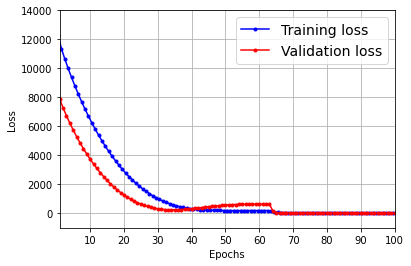

In [60]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 100, -1000, 14000])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()


Model seems to neither underfit nor overfit as the curves overlap towards the end

## (d) [5 marks]

Create a supervised learning dataset suitable for predicting 3 days ahead instead of 1 day ahead. Adjust the deep RNN in (c) so that it predicts 3 days ahead. Use 100 epochs and the Nadam optimizer. Using the test set, report the mean squared error and the accuracy for the movement direction for each of the 3 days ahead predictions.  Comment on the result and the learning curve.

**[Add your solution here]**

In [61]:
X_train_3, y_train_3 = ts_split(d_train.values.flatten(),target_steps=3)
X_valid_3, y_valid_3 = ts_split(d_valid.values.flatten(),target_steps=3)
X_test_3, y_test_3 = ts_split(d_test.values.flatten(),target_steps=3)

reset_session()

model_d = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1)),
    keras.layers.Lambda(lambda Y_pred: Y_pred[:, -3:])
])

model_d.compile(loss="mse", optimizer="nadam")
model_d_history = model_d.fit(X_train_3, y_train_3, epochs=100,
                validation_data=(X_valid_3, y_valid_3), verbose=0)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

ypred = model_d.predict(X_test_3[...,np.newaxis])[...,0]
print("Mean squared error is: ", mean_squared_error(y_test_3, ypred, multioutput="raw_values"))


#print("accuracy is: " , accuracy_score(np.diff(np.ravel(y_test_3))>=0,np.diff(np.ravel(ypred))>=0))

#print("accuracy is: " , accuracy_score(movement_test, movement_test_pred))

movement_test_1 = X_test_3[:,-1] < y_test_3[:,0].ravel()
movement_test_pred_1 = X_test_3[:,-1] < ypred[:,0].ravel()
print("accuracy is: ", accuracy_score(movement_test_1, movement_test_pred_1))

movement_test_2 = X_test_3[:,-1] < y_test_3[:,1].ravel()
movement_test_pred_2 = X_test_3[:,-1] < ypred[:,1].ravel()
print("accuracy is: ",accuracy_score(movement_test_2, movement_test_pred_2))

movement_test_3 = X_test_3[:,-1] < y_test_3[:,2].ravel()
movement_test_pred_3 = X_test_3[:,-1] < ypred[:,2].ravel()
print("accuracy is: ", accuracy_score(movement_test_3, movement_test_pred_3))

#model_d.evaluate(X_valid_3, y_valid_3)

Mean squared error is:  [1.17342239 1.25336965 1.32702782]
accuracy is:  0.49023569023569025
accuracy is:  0.49764309764309766
accuracy is:  0.5050505050505051


Looks like the model does not predict the direction of exchange rate well. 

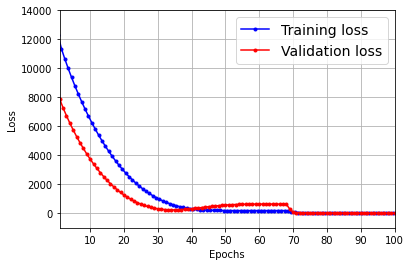

In [ ]:
plot_learning_curves(model_d_history.history["loss"], model_d_history.history["val_loss"])
plt.show()

Model does not overfit as the validation and trainign curves overlap after some epochs.